In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

from labdata.schema import *

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
#matplotlib.rcParams.update({'font.size': 18})

[2024-05-03 15:37:30,198][INFO]: Connecting mmelin@churchland-data.cmojfwfr0b9t.us-west-2.rds.amazonaws.com:3306
[2024-05-03 15:37:30,543][INFO]: Connected mmelin@churchland-data.cmojfwfr0b9t.us-west-2.rds.amazonaws.com:3306


In [2]:
Procedure() & 'procedure_type = "chronic implant"'

subject_name unique mouse id,procedure_type Defines procedures that are not an experimental session,procedure_datetime,user_name username,procedure_metadata,weighing_datetime,notetaker username,note_datetime
JC118,chronic implant,2023-09-11 18:00:00,couto,=BLOB=,None,None,None
JC119,chronic implant,2023-08-08 18:00:00,couto,=BLOB=,None,None,None
JC131,chronic implant,2023-07-19 20:00:00,couto,=BLOB=,2023-07-19 20:00:00,None,None
JC140,chronic implant,2023-12-05 18:00:00,couto,=BLOB=,None,None,None
JC142,chronic implant,2024-01-18 14:00:00,couto,=BLOB=,2024-01-18 14:00:00,None,None
MM008,chronic implant,2023-03-14 20:00:00,mmelin,=BLOB=,2023-03-14 20:00:00,None,None
MM009,chronic implant,2023-10-09 14:00:00,mmelin,=BLOB=,2023-10-09 14:00:00,None,None
MM010,chronic implant,2023-10-16 16:00:00,mmelin,=BLOB=,2023-10-16 16:00:00,None,None
MM011,chronic implant,2023-11-02 13:00:00,mmelin,=BLOB=,2023-11-02 13:00:00,None,None
MM012,chronic implant,2023-08-01 13:00:00,mmelin,=BLOB=,2023-08-01 13:00:00,None,None


In [3]:
#TODO: need to add neural data for MM010 and several JC mice so they will appear on the plot
Procedure() & 'procedure_type = "chronic explant"'

subject_name unique mouse id,procedure_type Defines procedures that are not an experimental session,procedure_datetime,user_name username,procedure_metadata,weighing_datetime,notetaker username,note_datetime
JC118,chronic explant,2023-10-07 16:00:00,couto,=BLOB=,None,None,None
JC119,chronic explant,2023-08-24 13:00:00,couto,=BLOB=,None,None,None
JC140,chronic explant,2023-12-20 13:00:00,couto,=BLOB=,None,None,None
JC142,chronic explant,2024-03-12 14:00:00,couto,=BLOB=,None,couto,2024-03-12 14:00:00
MM008,chronic explant,2023-06-17 16:00:00,mmelin,=BLOB=,None,None,None
MM009,chronic explant,2023-10-18 14:00:00,mmelin,=BLOB=,None,None,None
MM010,chronic explant,2023-10-27 14:00:00,mmelin,=BLOB=,None,None,None
MM011,chronic explant,2023-12-01 13:00:00,mmelin,=BLOB=,None,None,None
MM012,chronic explant,2024-01-22 13:00:00,mmelin,=BLOB=,None,None,None
MM013,chronic explant,2024-01-23 16:00:00,mmelin,=BLOB=,None,None,None


In [4]:
#TODO: MUST ADD JC141 subject and insertions and explant
#Subject().insert1(dict(subject_name='JC141',
#                       #subject_dob=, # TODO: add DOB
#                       subject_gender='M',
#                       strain_name='R26-LNL-GtACR1-Fred-Kv2.1',
#                       user_name='couto'))
#
#to_insert = dict(subject_name='JC140',
#                 procedure_type='chronic implant',
#                 procedure_datetime='2023-12-05 18:00:00',
#                 user_name='couto',)
#Procedure().insert1(to_insert, skip_duplicates=True) 
#
#to_insert = dict(subject_name='JC140',
#                 procedure_type='chronic explant',
#                 procedure_datetime='2023-12-20 13:00:00',
#                 user_name='couto',)
#Procedure().insert1(to_insert, skip_duplicates=True) 

In [5]:
EphysRecording.ProbeSetting()  & 'subject_name = "MM010"' # FIXME: missing MM010 right now.

subject_name unique mouse id,session_name session identifier,dataset_name,probe_num probe number,probe_id probe id to keep track or re-uses,configuration_id,sampling_rate sampling rate


In [6]:
# Get all the implantation and explantation data from the database
procedures = EphysRecording.ProbeSetting() * Procedure() & 'procedure_type LIKE "chronic%"'
procedures = pd.DataFrame(procedures.fetch('probe_id', 'subject_name', 'procedure_datetime','procedure_type', as_dict=True)).drop_duplicates()
#print(f'There are {(len(procedures.probe_id.unique()))} probes in the database')
procedures.head()

,subject_name,procedure_type,procedure_datetime,probe_id
0,JC142,chronic explant,2024-03-12 14:00:00,22420007912
1,JC142,chronic explant,2024-03-12 14:00:00,22420007982
44,MM008,chronic explant,2023-06-17 16:00:00,20097902741
45,MM008,chronic explant,2023-06-17 16:00:00,19454421152
46,MM008,chronic explant,2023-06-17 16:00:00,20097902851


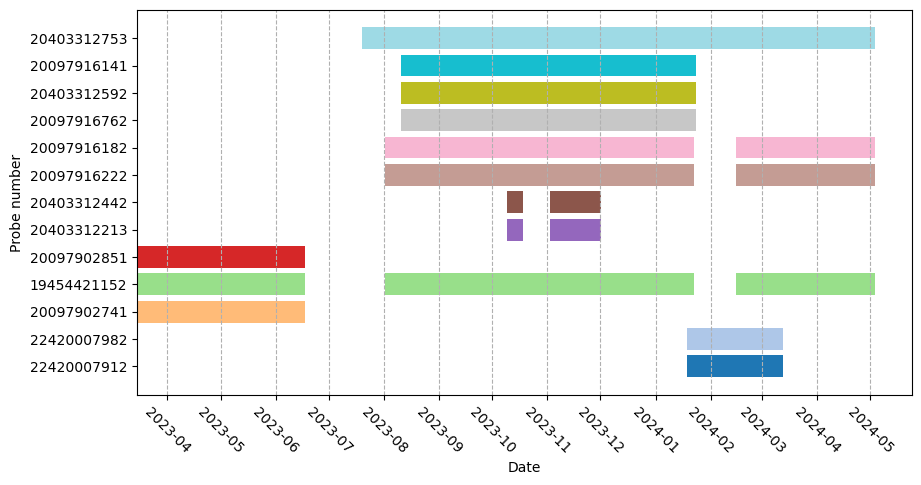

In [7]:
# Plot a Gantt chart for all probes used
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import  matplotlib.dates as mdates

color = list(cm.rainbow(np.linspace(0, 1, len(procedures.probe_id.unique()))))
color = list(cm.tab20(np.linspace(0, 1, len(procedures.probe_id.unique()))))
prbs, starts, ends, heights, cols = [], [], [], [], []
for prb_ind,prb in enumerate(procedures.probe_id.unique()):
    implant_times = procedures[(procedures.probe_id == prb) & (procedures.procedure_type == 'chronic implant')].procedure_datetime.values
    explant_times = procedures[(procedures.probe_id == prb) & (procedures.procedure_type == 'chronic explant')].procedure_datetime.values
    for implant in implant_times:
        explant = explant_times[explant_times > implant]
        explant = explant[0] if len(explant) else np.datetime64(datetime.now())
        starts.append(implant)
        #widths.append(np.datetime64(explant) - implant)
        ends.append(explant)
        heights.append(prb_ind)
        #cols.append(mpl_colors[prb_ind % len(mpl_colors)])
        cols.append(color[prb_ind])
    prbs.append(prb)

widths = np.array(ends) - np.array(starts)

fig, ax = plt.subplots(figsize=(10,5))
plt.barh(heights, widths, left=starts, color=cols)
plt.ylabel('Probe number')
plt.xlabel('Date')
plt.yticks(range(len(prbs)), prbs) # apply serial numbers
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.grid(which='major', axis='x', linestyle='--')
plt.xticks(rotation=-45)
plt.show()

In [8]:
implants = EphysRecording.ProbeSetting() * Procedure() & 'procedure_type LIKE "chronic_implant"'
mice = implants.fetch('subject_name', order_by='procedure_datetime') # sort by implant date
mice = pd.unique(mice)[::-1] #pd.unique preserves order unlike np.unique
mice

array(['MM018', 'JC142', 'MM011', 'MM009', 'MM013', 'MM012', 'JC131',
       'MM008'], dtype=object)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


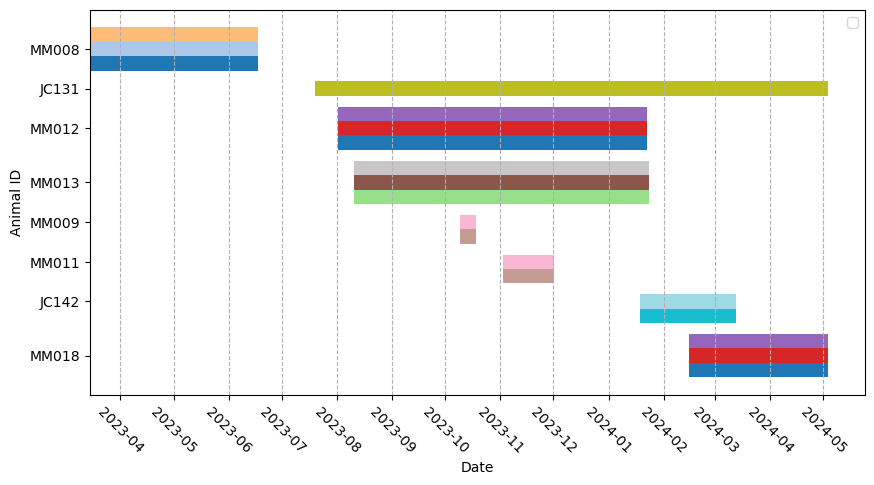

In [9]:
# similar to plot above, but put each mouse on a separate row
procedures = EphysRecording.ProbeSetting() * Procedure() & 'procedure_type LIKE "chronic%"'
probe_ids = np.unique(procedures.fetch('probe_id'))
color = list(cm.tab20(np.linspace(0, 1, len(probe_ids))))
label_locations, prbs, starts, ends, heights, cols = [], [], [], [], [], []

c = 0
for m in mice:
    query = procedures & f'subject_name = "{m}"'
    prbs = np.unique(query.fetch('probe_id'))
    label_locations.append(c + len(prbs) // 2)
    for p in prbs:
        implant_date = (query & f'probe_id = "{p}"' & 'procedure_type = "chronic implant"').fetch('procedure_datetime')[0]
        explant_dates = (query & f'probe_id = "{p}"' & 'procedure_type = "chronic explant"').fetch('procedure_datetime')
        explant_date = explant_dates[0] if len(explant_dates) else datetime.now()
        starts.append(implant_date)
        ends.append(explant_date)
        heights.append(c)
        cols.append(color[np.where(probe_ids == p)[0][0]])
        c += 1 
    c +=.75

widths = np.array(ends) - np.array(starts)

fig, ax = plt.subplots(figsize=(10,5))
plt.barh(heights, widths, left=starts, height=1, color=cols)
plt.legend()
plt.ylabel('Animal ID')
plt.xlabel('Date')
plt.yticks(label_locations, mice) # apply serial numbers
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.grid(which='major', axis='x', linestyle='--')
plt.xticks(rotation=-45)
plt.show()

In [10]:
#TODO: add extractions to db and plot probe extraction success 
ProbeExtraction()

subject_name unique mouse id,procedure_type Defines procedures that are not an experimental session,procedure_datetime,probe_id probe id to keep track or re-uses,extraction_successful boolean for successfull or not
JC142,chronic explant,2024-03-12 14:00:00,22420007912,1
JC142,chronic explant,2024-03-12 14:00:00,22420007982,1
